In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pylab as plt
%matplotlib inline
import catboost as cbt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns=50

# Task 1
## 1. Load the data

- Objective of this project is to build a classifier to predict if a customer churn will occur or not.
- The structure of the dataset is table.

In [2]:
df=pd.read_csv('churn_dataset.csv')
print('The data shape is',df.shape)

The data shape is (7043, 21)


In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## 2. Looking for Missing Values

1. The column TotalCharges has null values.
2. 11 records has null values, that is, around 0.27% of the data set.
3. Let's replace those whitespaces by 0 since they are new to this program accoring to the column tenure.


In [5]:
pd.DataFrame({'Feature':df.isnull().sum().index.values,'# of Missing Valuses':df.isnull().sum().values})

,Feature,# of Missing Valuses
0,customerID,0
1,gender,0
2,SeniorCitizen,0
3,Partner,0
4,Dependents,0
5,tenure,0
6,PhoneService,0
7,MultipleLines,0
8,InternetService,0
9,OnlineSecurity,0


#### As shown below, there are 11 missing values in the column TotalCharge.

In [6]:
df.TotalCharges.map(str.isspace).sum()

11

In [7]:
df.loc[df.TotalCharges.map(str.isspace),'TotalCharges']=0
df['TotalCharges']=df.TotalCharges.astype('float64')

In [8]:
df.loc[df.TotalCharges==0,:].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No


#### Next, check other object -- features.

In [9]:
obj_col=df.columns.values[df.dtypes=='object']
print(obj_col)

['customerID' 'gender' 'Partner' 'Dependents' 'PhoneService'
 'MultipleLines' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies'
 'Contract' 'PaperlessBilling' 'PaymentMethod' 'Churn']


In [10]:
pd.DataFrame({'Obj_feat':np.delete(obj_col,0,0),
              '# of Levels':[df[x].nunique() for x in np.delete(obj_col,0,0)],
              'Levels':[df[x].unique() for x in np.delete(obj_col,0,0)]})

,Obj_feat,# of Levels,Levels
0,gender,2,"[Female, Male]"
1,Partner,2,"[Yes, No]"
2,Dependents,2,"[No, Yes]"
3,PhoneService,2,"[No, Yes]"
4,MultipleLines,3,"[No phone service, No, Yes]"
5,InternetService,3,"[DSL, Fiber optic, No]"
6,OnlineSecurity,3,"[No, Yes, No internet service]"
7,OnlineBackup,3,"[Yes, No, No internet service]"
8,DeviceProtection,3,"[No, Yes, No internet service]"
9,TechSupport,3,"[No, Yes, No internet service]"


### Plots of the Categorical Variables



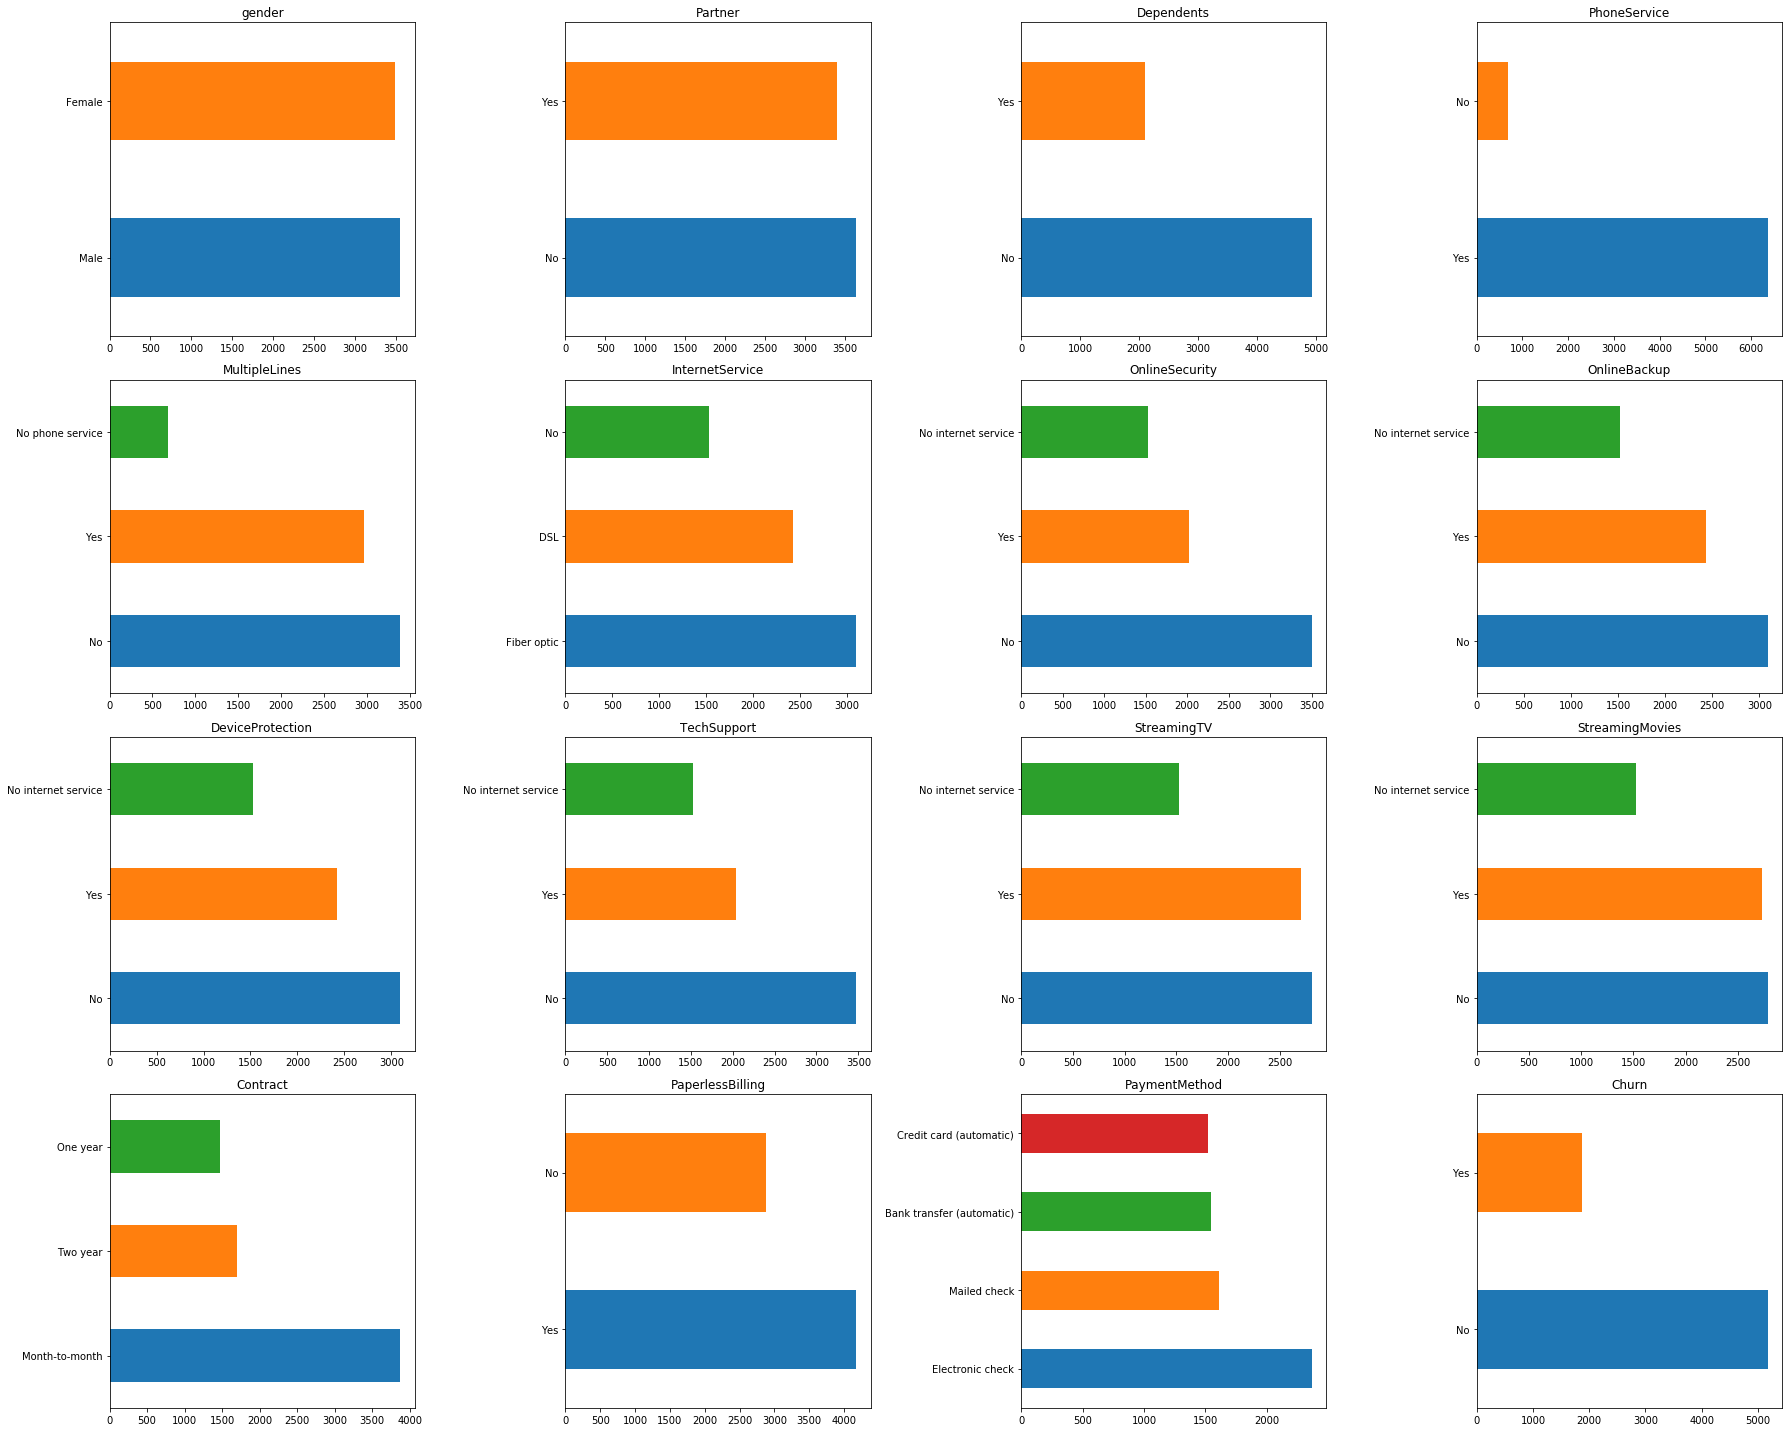

In [11]:
fig=plt.figure()
i=1
for x in np.delete(obj_col,0,0):
    df[x].value_counts().plot(kind='barh',figsize=(25,20),title=str(x),ax=fig.add_subplot(4,4,i))
    i+=1
fig.tight_layout()    

# Task 2
1. Pearson correlation is statistically not an appropriate measure for relation between two categorical features. Mutual information may be better. But, on Kaggle, it is very popular to plot the heatmap after variable encoding. Anyway, a heatmap is included here. According to the plot, we can see that the input features are not highly correlated with target variable.

2. Since I am going to use tree-based methods and the dimension of the data is not high, I am not going to do feature selection here. 


3. Since there are not many features, we can encode these categorical features manually. I did not use one-hot-encoding because LightGBM and Catboost prefer Label-Encoding.


In [12]:
df['PhoneService']=df.PhoneService.map({'Yes':1,'No':0}) # Redundant varible

df['MultipleLines']=df.MultipleLines.map(pd.Series([0,1,2],index=df.MultipleLines.unique()))

df['Churn']=df.Churn.map({'Yes':1,'No':0})

df['InternetService']=df.InternetService.map(pd.Series([1,2,0],df.InternetService.unique())) # Redundant varible

df['PaperlessBilling']=df['PaperlessBilling'].map({'Yes':1,'No':0})

df['Partner']=df.Partner.map({'Yes':1,'No':0})

df['Dependents']=df.Dependents.map({'Yes':1,'No':0})

dic={'Yes':2,'No':1,'No internet service':0}
#Mannually encoding the categorical variables.

net_col=df.columns[df[df=='No internet service'].any()].tolist()

for x in net_col:
    df[x]=df[x].map(dic)

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['gender']=le.fit_transform(df.gender)

df['Contract']=le.fit_transform(df.Contract)

df['PaymentMethod']=le.fit_transform(df.PaymentMethod)

del df['customerID']#df.set_index('customerID',inplace=True)

#### The heatmap

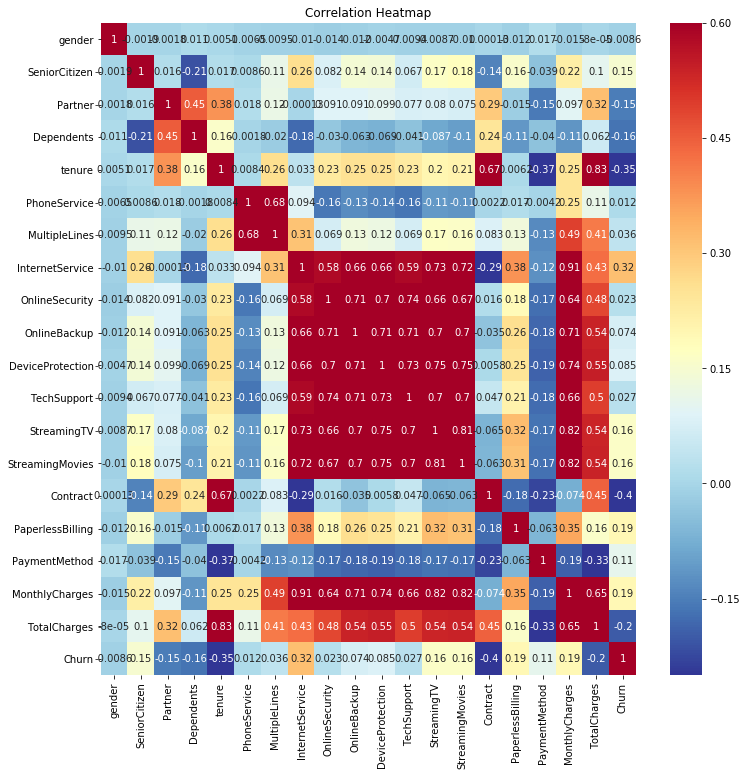

In [14]:
plt.figure(figsize = (12, 12))

# Heatmap of correlations
sns.heatmap(df.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

# Task 3 
## 3. Build Three Simple Models



1. Here, I build three models, random-forests, Catboost and LightGBM in their default settings, basically. Random Forests can be seen as a baseline.

2. The metrics used here is ROC_AUC.  The reasons to use ROC_AUC are : 1) it focuses on the rank; 2) we can determine the optimal cut off values; 3) when data are imbalanced. 

3. The 5-fold cross validation is used to evaluate the performance of the models.

4. We can see that Catboost performs slightly better than LightGMB. When data set is not large, LightGBM is notorious for overfitting. But, the cross validation scores of Catboost and LighGBM are biased because during each iteration, the validation set is used to train the model too.

5. Why I choose these three models?
    - Tree–based methods are easy to use especially for heterogeneous data.
    - Catboost is newly developed model by Yandex mainly focusing on categorical features.
    - LightGBM is the most popular model on Kaggle, because it is fast and high-performance. But, it does not work well on small data set.
    - LightGBM and Catboost can handle missing values. It is very important because the real data are much messier than scientific data. And, data imputation is dangerous in some case. For categorical features, we can code "missing" as a new class. However, missing data in numerical features are more concerning.



In [15]:
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
y=df.pop('Churn')## Target Variable

### 3.1 Random Forests

In [16]:
rf=RandomForestClassifier(n_estimators=300)
cv=cross_val_score(rf,df,y,scoring='roc_auc',cv=folds)
print(cv)
print('The cross validation score of rondom forests: ',cv.mean())

[0.82874301 0.82872724 0.81683422 0.82674153 0.84038047]
The cross validation score of rondom forests:  0.8282852949191495


### 3.2 Catboost


In [17]:
scr=np.zeros(5)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(df)):
    
    trn_x, trn_y = df.iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = df.iloc[val_idx], y.iloc[val_idx]

    clf = cbt.CatBoostClassifier(
        #iterations=2000,
        eval_metric='AUC',

    )

    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y),(val_x, val_y)], 
            verbose=200, 
            early_stopping_rounds=50, #30
            cat_features=[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16]
           )
    scr[n_fold]=clf.get_best_score()['validation_1']['AUC']
print('The cross validation score is ', scr.mean())

0:	test: 0.8078092	test1: 0.8142131	best: 0.8142131 (0)	total: 91.1ms	remaining: 1m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8585874933
bestIteration = 94

Shrink model to first 95 iterations.
0:	test: 0.8158116	test1: 0.8232088	best: 0.8232088 (0)	total: 37.4ms	remaining: 37.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8582024033
bestIteration = 147

Shrink model to first 148 iterations.
0:	test: 0.8116556	test1: 0.8034964	best: 0.8034964 (0)	total: 46.3ms	remaining: 46.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8323031012
bestIteration = 63

Shrink model to first 64 iterations.
0:	test: 0.8191006	test1: 0.8116533	best: 0.8116533 (0)	total: 72.9ms	remaining: 1m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8477084899
bestIteration = 97

Shrink model to first 98 iterations.
0:	test: 0.8227015	test1: 0.8094384	best: 0.8094384 (0)	total: 43.1ms	remaining: 43s
200:	test: 0.864485

### 3.3 LightGBM

In [18]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(10,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [19]:
oof_preds=pd.DataFrame()
oof_preds = np.zeros(df.shape[0])   
feature_importance_df = pd.DataFrame()


for n_fold, (trn_idx, val_idx) in enumerate(folds.split(df)):
    
    trn_x, trn_y = df.iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = df.iloc[val_idx], y.iloc[val_idx]

    clf = lgb.LGBMClassifier(n_estimators=200,
       learning_rate=0.01,
        max_depth=6,
        #silent=-1,
        #verbose=-1,
        #eval_metric='AUC'
    )

    clf.fit(trn_x, trn_y, 
            eval_set= (val_x, val_y), #trn_x, trn_y),
            eval_metric='auc',
            verbose=200, early_stopping_rounds=50, #30
            categorical_feature=[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16]
           )


    scr[n_fold]=dict(clf.best_score_)['valid_0']['auc']

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)  
    


Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.428397	valid_0's auc: 0.852943
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.428397	valid_0's auc: 0.852943
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.420355	valid_0's auc: 0.855098
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.420355	valid_0's auc: 0.855098
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.518934	valid_0's auc: 0.832344
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.420165	valid_0's auc: 0.84056
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.420165	valid_0's auc: 0.84056
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.401132	valid_0's auc: 0.8

the cross validation score is  0.8468233213986018


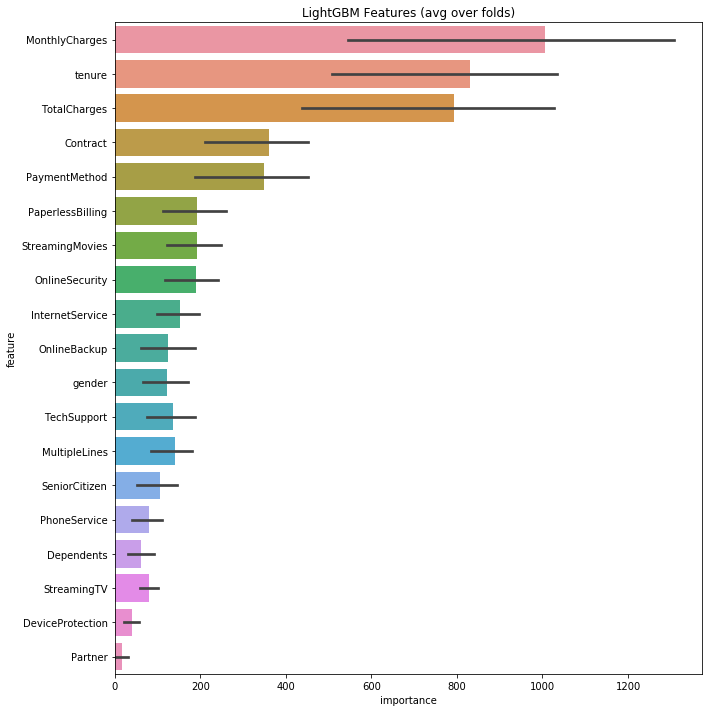

In [20]:
display_importances(feature_importance_df)
print('the cross validation score is ',scr.mean() )